## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [35]:
import os
import json

In [33]:
parent_dir = '../D2_data'
meta_dir = 'meta2'
audio_dir = 'audio_data_OTR'

In [10]:
os.listdir(os.path.join(parent_dir, audio_dir))[:5]

['5fa97487838deb0024876431_5_25.wav',
 '5fb2bc30838deb00248b073a_5_25.wav',
 '5fc67750310fc0002406a1bc_5_25.wav',
 '6001ce21fafce61f131769af_25_45.wav',
 '5fd3ab79d95b1b0024963792_105_125.wav']

## Plotting the audio file's waveform and its spectrogram

In [11]:
data, sampling_rate = librosa.load(os.path.join(parent_dir, audio_dir, '5fa97487838deb0024876431_5_25.wav'))

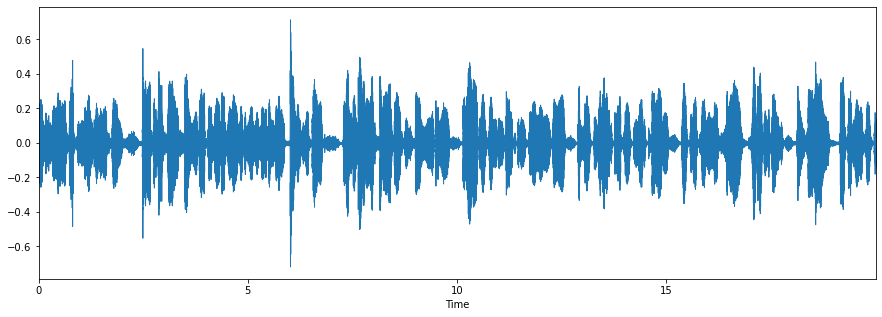

In [13]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [36]:
def get_hike_datalist(category, data_dir, meta_path):
    with open(meta_path) as f:
        meta_list = json.load(f)
        audiolist = np.array([os.path.join(data_dir, i[0]) for i in meta_list if i[2] in category])
        scorelist = np.array([i[1] for i in meta_list if i[2] in category])
        f.close()
    return audiolist, scorelist

In [49]:
def set_mp(processes=8):
    import multiprocessing as mp

    def init_worker():
        import signal
        signal.signal(signal.SIGINT, signal.SIG_IGN)

    global pool
    try:
        pool.terminate()
    except:
        pass

    if processes:
        pool = mp.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None
    return pool

In [131]:
def load_data(data_path, offeset, spec_len=862):
    X, sample_rate = librosa.load(data_path, res_type='kaiser_fast',sr=22050*2,offset=offeset)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    time = len(mfccs)
    randtime = np.random.randint(0, time-spec_len)
    mfccs = mfccs[randtime:randtime+spec_len]
    return mfccs

In [132]:
def find_mfcc_length(data_path, duration):
    X, sample_rate = librosa.load(data_path, res_type='kaiser_fast',sr=22050*2,duration=duration)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    return len(mfccs)

In [113]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dim, mp_pooler, spec_len, augmentation=True, batch_size=32, shuffle=True, normalize=True):
        'Initialization'
        self.dim = dim
        self.normalize =normalize
        self.mp_pooler = mp_pooler
        self.spec_len = spec_len

        self.labels = labels
        self.shuffle = shuffle
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation_mp(list_IDs_temp, indexes)

        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation_mp(self, list_IDs_temp, indexes):
        X = [self.mp_pooler.apply_async(load_data, args=(data_path, 0, spec_len)) for data_path in list_IDs_temp]
        X = np.expand_dims(np.array([p.get() for p in X]), -1)
        y = self.labels[indexes]

        return X, y


    def __data_generation(self, list_IDs_temp, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size,) + self.dim)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i, :, :, 0] = load_data(ID, duration, offeset)
            # Store class
            y[i] = self.labels[indexes[i]]

        return X, y


In [114]:
# df = pd.DataFrame(columns=['feature'])
# mylist = [i for i in os.listdir(os.path.join(parent_dir, audio_dir)) if i.endswith('.wav')]
# bookmark=0
# for index,y in enumerate(mylist):
#     X, sample_rate = librosa.load(os.path.join(parent_dir, audio_dir, y), res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#     sample_rate = np.array(sample_rate)
#     mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
#     feature = mfccs
#     #[float(i) for i in feature]
#     #feature1=feature[:135]
#     df.loc[bookmark] = [feature]
#     bookmark=bookmark+1   

In [146]:
seed=2
duration = 10
batch_size=16
epochs=300
mp_pooler = set_mp(processes=8)
spec_len = find_mfcc_length(os.path.join(parent_dir, audio_dir, '5fa97487838deb0024876431_5_25.wav'), duration)

In [134]:
X = np.empty((16,) + (256,1))

In [150]:
trnlist, trnlb = get_hike_datalist(['low','high'], data_dir=os.path.join(parent_dir, audio_dir), meta_path=os.path.join(parent_dir, meta_dir, 'hike_train_{}.json'.format(seed)))
trn_gen = DataGenerator(trnlist, trnlb,  (spec_len,1), mp_pooler, spec_len, batch_size=batch_size)

In [139]:
vallist, vallb = get_hike_datalist(['low','high'], data_dir=os.path.join(parent_dir, audio_dir), meta_path=os.path.join(parent_dir, meta_dir, 'hike_val_{}.json'.format(seed)))
val_data = [mp_pooler.apply_async(load_data, args=(data_path, 0, spec_len)) for data_path in vallist]
val_data = np.expand_dims(np.array([p.get() for p in val_data]), -1)
vallb = np.array(vallb)

## Changing dimension for CNN model

In [76]:
# x_traincnn =np.expand_dims(trn_data, axis=2)
# x_valcnn= np.expand_dims(val_data, axis=2)

In [157]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(spec_len,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1))
# model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [158]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 862, 256)          1536      
_________________________________________________________________
activation_30 (Activation)   (None, 862, 256)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 862, 128)          163968    
_________________________________________________________________
activation_31 (Activation)   (None, 862, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 862, 128)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 107, 128)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 107, 128)         

In [159]:
# model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.compile(optimizer=opt, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

In [160]:
model.load_weights('./saved_models/Emotion_Voice_Detection_Model.h5', by_name=True, skip_mismatch=True)

In [161]:
model_path = 'saved_models'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(model_path, 'weights-{epoch:02d}-{loss:.3f}.h5'),
                                             monitor='loss',
                                             mode='min',
                                             save_best_only=True,
                                             period=20,
                                             )]

### Removed the whole training part for avoiding unnecessary long epochs list

In [162]:
model.fit_generator(trn_gen,
                      steps_per_epoch=int(len(trnlb)//batch_size),
                      epochs=epochs,
                      max_queue_size=10,
                      validation_data=(val_data, vallb),
                      validation_freq=1,
                      callbacks=callbacks,
                      use_multiprocessing=False,
                      workers=1,
                      verbose=1)

Epoch 1/300
40/40 [==============================] - 23s 565ms/step - loss: 11.5113 - mean_squared_error: 18.1223 - val_loss: 7.2097 - val_mean_squared_error: 11.3785
Epoch 2/300
40/40 [==============================] - 23s 566ms/step - loss: 6.3805 - mean_squared_error: 9.6494 - val_loss: 7.8930 - val_mean_squared_error: 8.8969
Epoch 3/300
40/40 [==============================] - 23s 570ms/step - loss: 6.2268 - mean_squared_error: 8.3623 - val_loss: 8.7826 - val_mean_squared_error: 8.0638
Epoch 4/300
40/40 [==============================] - 23s 568ms/step - loss: 6.2641 - mean_squared_error: 7.8060 - val_loss: 7.9104 - val_mean_squared_error: 7.6530
Epoch 5/300
40/40 [==============================] - 23s 568ms/step - loss: 6.0071 - mean_squared_error: 7.4473 - val_loss: 7.5746 - val_mean_squared_error: 7.3511
Epoch 6/300
40/40 [==============================] - 23s 568ms/step - loss: 6.1543 - mean_squared_error: 7.2349 - val_loss: 6.5931 - val_mean_squared_error: 7.1609
Epoch 7/300
4

In [102]:
cnnhistory=model.fit(trn_data, trnlb, batch_size=batch_size, epochs=epochs, validation_data=(val_data, vallb))

Train on 650 samples, validate on 61 samples
Epoch 1/300
650/650 [==============================] - 3s 4ms/step - loss: 21.1950 - mean_squared_error: 31.5035 - val_loss: 5.8364 - val_mean_squared_error: 20.4232
Epoch 2/300
650/650 [==============================] - 3s 4ms/step - loss: 6.2853 - mean_squared_error: 15.8859 - val_loss: 9.8438 - val_mean_squared_error: 13.3429
Epoch 3/300
650/650 [==============================] - 3s 4ms/step - loss: 6.1689 - mean_squared_error: 11.9749 - val_loss: 8.1178 - val_mean_squared_error: 11.0009
Epoch 4/300
650/650 [==============================] - 3s 4ms/step - loss: 6.1198 - mean_squared_error: 10.3103 - val_loss: 9.6540 - val_mean_squared_error: 9.8363
Epoch 5/300
650/650 [==============================] - 2s 4ms/step - loss: 6.0435 - mean_squared_error: 9.4366 - val_loss: 10.3186 - val_mean_squared_error: 9.1431
Epoch 6/300
650/650 [==============================] - 3s 4ms/step - loss: 5.9919 - mean_squared_error: 8.8552 - val_loss: 8.3157 -

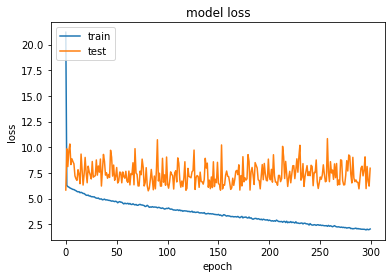

In [103]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [112]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\mites\Documents\Cognitive\Final Exam\saved_models\Emotion_Voice_Detection_Model.h5 


In [133]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [137]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 72.73%


## Predicting emotions on the test data

In [138]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

319/319 [==============================] - 0s     


In [139]:
preds

array([[  3.49815641e-12,   1.18043589e-10,   1.13181663e-19, ...,
          1.80016723e-05,   7.36836637e-06,   1.14132257e-04],
       [  3.87504338e-16,   5.73074694e-23,   1.31673211e-14, ...,
          1.75147681e-04,   1.85760673e-05,   9.99805748e-01],
       [  8.39285008e-07,   3.43896300e-11,   5.38965035e-03, ...,
          9.93317604e-01,   1.99900052e-04,   1.05243188e-03],
       ..., 
       [  3.49616457e-04,   1.94651744e-04,   6.65218568e-06, ...,
          1.67340226e-02,   6.44345134e-02,   9.10043001e-01],
       [  4.23396705e-06,   1.59581254e-11,   6.03030126e-12, ...,
          6.36715861e-03,   9.64888096e-01,   2.34207995e-02],
       [  3.69524572e-31,   0.00000000e+00,   0.00000000e+00, ...,
          5.24333927e-07,   9.99998808e-01,   6.36476927e-10]], dtype=float32)

In [115]:
preds1=preds.argmax(axis=1)

In [116]:
preds1

array([6, 9, 7, 1, 7, 8, 1, 2, 5, 8, 7, 1, 9, 9, 4, 0, 5, 0, 5, 8, 4, 1, 5,
       9, 7, 5, 7, 1, 7, 5, 8, 1, 8, 9, 2, 2, 1, 8, 6, 0, 5, 9, 1, 0, 7, 5,
       5, 7, 7, 0, 0, 7, 0, 0, 6, 5, 3, 7, 5, 8, 5, 4, 8, 8, 9, 7, 2, 8, 6,
       1, 5, 6, 8, 6, 5, 3, 4, 8, 8, 9, 9, 0, 8, 9, 4, 5, 0, 0, 5, 5, 7, 9,
       4, 7, 8, 6, 9, 5, 6, 8, 1, 7, 0, 8, 8, 7, 3, 2, 7, 8, 7, 9, 7, 9, 5,
       7, 8, 6, 0, 1, 6, 9, 1, 5, 8, 7, 1, 8, 6, 9, 3, 7, 7, 4, 6, 5, 8, 8,
       1, 0, 5, 0, 7, 6, 5, 7, 4, 9, 2, 5, 4, 7, 5, 6, 8, 5, 5, 4, 8, 8, 2,
       7, 5, 7, 6, 9, 8, 9, 9, 0, 2, 5, 7, 8, 3, 0, 4, 6, 6, 9, 9, 9, 3, 8,
       1, 7, 2, 5, 8, 1, 8, 4, 4, 8, 5, 2, 9, 9, 5, 6, 0, 5, 9, 0, 8, 7, 4,
       6, 6, 3, 9, 5, 9, 6, 1, 7, 5, 7, 8, 4, 9, 2, 5, 6, 6, 4, 2, 1, 8, 2,
       7, 5, 7, 3, 5, 6, 8, 7, 1, 6, 0, 0, 4, 7, 4, 4, 4, 4, 4, 0, 8, 1, 6,
       7, 4, 8, 7, 8, 2, 9, 6, 2, 7, 8, 3, 9, 9, 7, 2, 5, 7, 2, 9, 5, 5, 7,
       8, 5, 6, 8, 1, 2, 5, 9, 4, 5, 5, 6, 7, 8, 7, 0, 9, 5, 9, 5, 9, 7, 8,
       1, 2,

In [117]:
abc = preds1.astype(int).flatten()

In [118]:
predictions = (lb.inverse_transform((abc)))

In [119]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_calm
4,male_fearful
5,male_happy
6,female_calm
7,female_fearful
8,male_angry
9,male_happy


In [120]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [121]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_fearful
4,male_fearful
5,male_happy
6,female_calm
7,female_angry
8,male_angry
9,male_happy


In [122]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [128]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_angry,male_angry
172,male_fearful,male_fearful
173,male_happy,male_happy
174,female_happy,female_happy
175,female_angry,female_angry
176,female_angry,female_sad
177,male_sad,male_calm
178,male_angry,male_calm
179,male_sad,male_sad


In [129]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [130]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [131]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [485]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


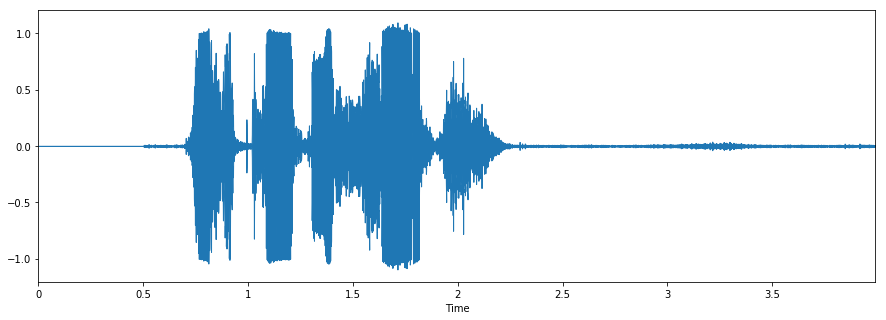

In [486]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [487]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [488]:
livedf2= pd.DataFrame(data=livedf2)

In [489]:
livedf2 = livedf2.stack().to_frame().T

In [490]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [491]:
twodim= np.expand_dims(livedf2, axis=2)

In [492]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s


In [493]:
livepreds

array([[  9.24052530e-22,   0.00000000e+00,   3.62402176e-26,
          1.30680162e-36,   4.47264152e-28,   1.00000000e+00,
          1.80208343e-30,   2.76873961e-27,   3.62227194e-23,
          1.67396652e-11]], dtype=float32)

In [494]:
livepreds1=livepreds.argmax(axis=1)

In [495]:
liveabc = livepreds1.astype(int).flatten()

In [496]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)